## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.4, 0.5]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0811 10:44:40.456697  8388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 10:44:40.457693  8388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 10:44:40.460686  8388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 10:44:40.546734  8388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.40, reduce_patient: 5


W0811 10:44:40.730223  8388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 10:44:40.738202  8388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0811 10:44:40.811951  8388 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 73us/step - loss: 1.4090 - acc: 0.5100 - val_loss: 1.5735 - val_acc: 0.4524
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3899 - acc: 0.5172 - val_loss: 1.5651 - val_acc: 0.4522
Epoch 15/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3718 - acc: 0.5235 - val_loss: 1.5586 - val_acc: 0.4543
Epoch 16/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3543 - acc: 0.5301 - val_loss: 1.5512 - val_acc: 0.4554
Epoch 17/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.3379 - acc: 0.5360 - val_loss: 1.5424 - val_acc: 0.4632
Epoch 18/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3236 - acc: 0.5422 - val_loss: 1.5418 - val_acc: 0.4623
Epoch 19/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3073 - acc: 0.5481 - val_loss: 1.5378 - val_acc: 0.4648
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 5s 91us/step - loss: 2.3406 - acc: 0.2357 - val_loss: 2.1323 - val_acc: 0.2923
Epoch 2/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.9063 - acc: 0.3427 - val_loss: 1.9404 - val_acc: 0.3406
Epoch 3/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.7671 - acc: 0.3852 - val_loss: 1.8137 - val_acc: 0.3687
Epoch 4/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.6915 - acc: 0.4088 - val_loss: 1.7550 - val_acc: 0.3907
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.6355 - acc: 0.4293 - val_loss: 1.7131 - val_acc: 0.4008
Epoch 6/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5922 - acc: 0.4450 - val_loss: 1.6778 - val_acc: 0.4142
Epoch 7/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5549 - acc: 0.4576 - val_loss: 1.6590 - val_acc: 0.4173
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 4s 81us/step - loss: 0.4402 - acc: 0.8743 - val_loss: 1.5371 - val_acc: 0.5248
Epoch 24/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.4233 - acc: 0.8793 - val_loss: 1.5789 - val_acc: 0.5205
Epoch 25/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.4090 - acc: 0.8857 - val_loss: 1.5741 - val_acc: 0.5210
Numbers of exp: 5, reduce_factor: 0.40, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_laye

50000/50000 [==============================] - 4s 83us/step - loss: 1.1007 - acc: 0.6210 - val_loss: 1.4437 - val_acc: 0.4982
Epoch 11/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.0695 - acc: 0.6347 - val_loss: 1.4717 - val_acc: 0.4805
Epoch 12/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.0392 - acc: 0.6475 - val_loss: 1.4494 - val_acc: 0.4901
Epoch 13/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.0107 - acc: 0.6583 - val_loss: 1.4438 - val_acc: 0.4936
Epoch 14/25
50000/50000 [==============================] - 4s 82us/step - loss: 0.9827 - acc: 0.6705 - val_loss: 1.4593 - val_acc: 0.4920

Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.2000003557186574e-05.
Epoch 15/25
50000/50000 [==============================] - 4s 83us/step - loss: 0.9422 - acc: 0.6871 - val_loss: 1.4216 - val_acc: 0.4952
Epoch 16/25
50000/50000 [==============================] - 4s 83us/step - loss: 0.9234 - acc: 0.6941 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.8064 - acc: 0.3747 - val_loss: 3.4584 - val_acc: 0.2110
Epoch 2/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5378 - acc: 0.4573 - val_loss: 2.2919 - val_acc: 0.2835
Epoch 3/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4333 - acc: 0.4961 - val_loss: 2.1254 - val_acc: 0.3054
Epoch 4/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3588 - acc: 0.5201 - val_loss: 2.1296 - val_acc: 0.3118
Epoch 5/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2986 - acc: 0.5428 - val_loss: 2.3195 - val_acc: 0.2959
Epoch 6/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2425 - acc: 0.5626 - val_loss: 2.3211 - val_acc: 0.3087
Epoch 7/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2031 - acc: 0.5766 - val_loss: 1.7975 - val_ac

50000/50000 [==============================] - 4s 80us/step - loss: 0.7305 - acc: 0.7611 - val_loss: 1.9371 - val_acc: 0.4377
Epoch 24/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.7054 - acc: 0.7689 - val_loss: 1.9981 - val_acc: 0.4035
Epoch 25/25
50000/50000 [==============================] - 4s 79us/step - loss: 0.6791 - acc: 0.7812 - val_loss: 1.8621 - val_acc: 0.4486
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_laye

50000/50000 [==============================] - 4s 81us/step - loss: 1.1979 - acc: 0.5871 - val_loss: 1.5623 - val_acc: 0.4598
Epoch 11/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1659 - acc: 0.5980 - val_loss: 1.6021 - val_acc: 0.4468
Epoch 12/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1337 - acc: 0.6122 - val_loss: 1.5493 - val_acc: 0.4565
Epoch 13/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.1047 - acc: 0.6242 - val_loss: 1.5065 - val_acc: 0.4781
Epoch 14/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.0770 - acc: 0.6324 - val_loss: 1.6021 - val_acc: 0.4398
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.0482 - acc: 0.6456 - val_loss: 1.6025 - val_acc: 0.4492
Epoch 16/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.0234 - acc: 0.6539 - val_loss: 1.4939 - val_acc: 0.4803
Epoch 17/25
50000/50000 [=====================

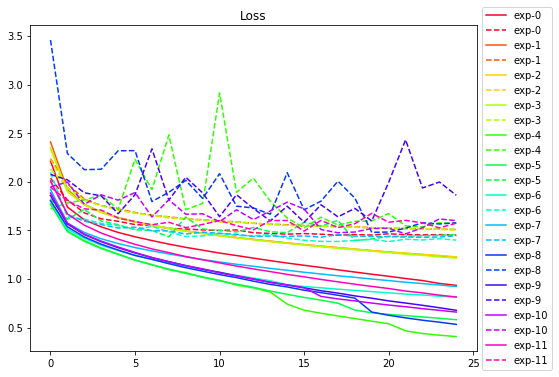

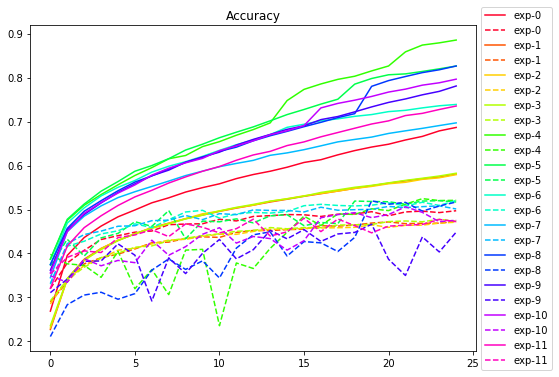

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()